# 2 Convolutional Neural Network

## 2-1
<style>
    .red {
        color: red;
    }
    .blue {
        color: skyblue;
    }
</style>

Please implement a CNN for image recognition by using **CIFAR-10**, then **plot** the <span class="blue">learning curve</span> and the <span class="blue">accuracy rate</span> of training and test data.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as data_utils
from tqdm import *

# use cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# CNN for CIFAR-10
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = torch.nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = torch.nn.Conv2d(32, 32, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.bn3 = torch.nn.BatchNorm2d(32)
        self.bn4 = torch.nn.BatchNorm2d(32)
        self.pool = torch.nn.AvgPool2d(2, 2)
        self.fc1 = torch.nn.Linear(32 * 8 * 8, 48)
        self.fc2 = torch.nn.Linear(48 * 1 * 1, 10)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.bn4(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Label {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'dear': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


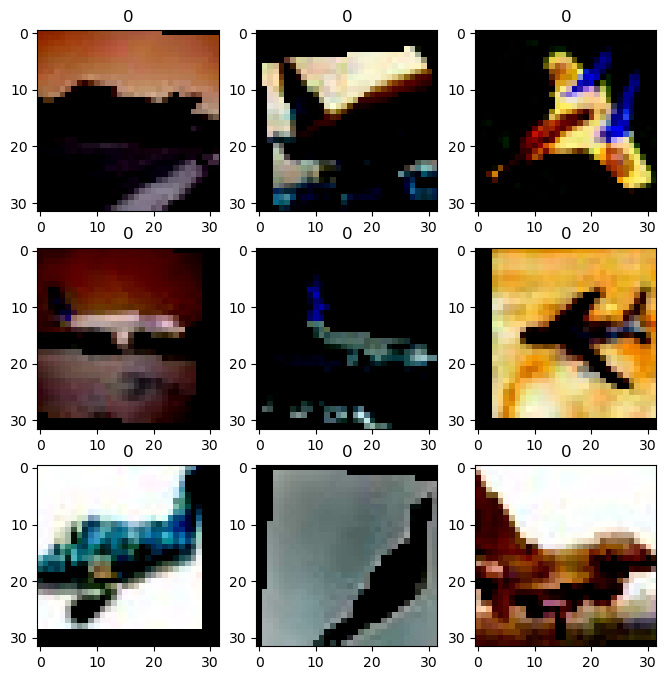

In [3]:
# load jpg images from folder and convert to tensor
def load_data(path):
    # data augmentation
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        torchvision.transforms.RandomHorizontalFlip(p=0.15),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    data = torchvision.datasets.ImageFolder(path, transform=transform)
    return data

# load data
train_data = load_data('./CIFAR-10/train')
test_data = load_data('./CIFAR-10/test')

print('Label', train_data.class_to_idx)

# show train data image and label
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, label = train_data[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [4]:
train_loader = data_utils.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=8)
test_loader = data_utils.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=8)

In [5]:
model = CNN().to(device)

train_acc, test_acc = [], []
train_loss, test_loss = [], []

epoch = 100
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for i in range(epoch):
    train_loss_sum = 0
    train_acc_sum = 0
    test_loss_sum = 0
    test_acc_sum = 0

    model.train()
    train_loop = tqdm((train_loader), total=len(train_loader))
    for j, (images, labels) in enumerate(train_loop):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_acc_sum += (predicted == labels).sum().item()
        train_loop.set_description(f'Training, Epoch [{i + 1}/{epoch}]')
        train_loop.set_postfix(loss=train_loss_sum / (j + 1), acc=train_acc_sum / ((j + 1) * 64))

    model.eval()
    test_loop = tqdm((test_loader), total=len(test_loader))
    with torch.no_grad():
        for j, (images, labels) in enumerate(test_loop):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss_sum += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_acc_sum += (predicted == labels).sum().item()
            test_loop.set_description(f'Testing, Epoch [{i + 1}/{epoch}]')
            test_loop.set_postfix(loss=test_loss_sum / (j + 1), acc=test_acc_sum / ((j + 1) * 64))

    train_loss.append(train_loss_sum / len(train_loader))
    train_acc.append(train_acc_sum / len(train_loader.dataset))
    test_loss.append(test_loss_sum / len(test_loader))
    test_acc.append(test_acc_sum / len(test_loader.dataset))

Testing, Epoch [100/100]: 100%|██████████| 7/7 [00:00<00:00, 15.60it/s, acc=0.511, loss=1.48]


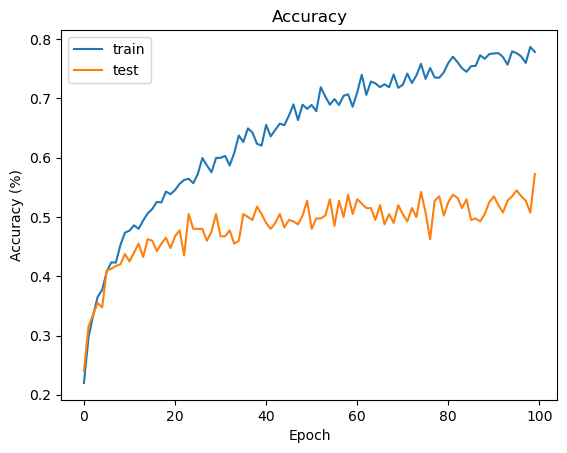

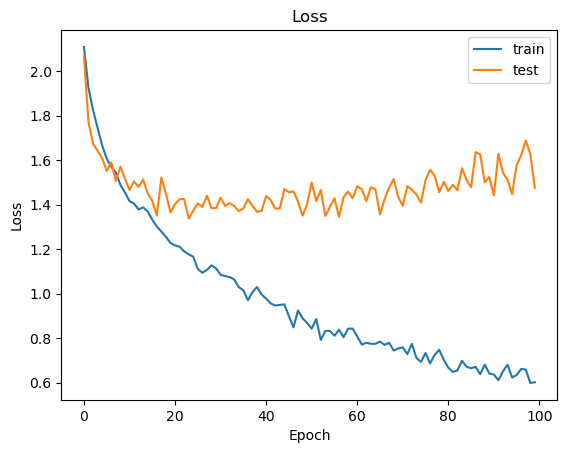

In [6]:
# plot train and test accuracy
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# plot train and test loss
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2-2

In order to deal with a real-world problem, we may stack some additional layers in the Deep Neural Network which results in the improved accuracy and performance. 

But it has been found that there is a maximum threshold for depth with the traditional convolutional neural network model. 

The problem of training a very deep network has been alleviated with the introduction of **ResNet** or residual network.

<style>
    .red {
        color: red;
    }
    .blue {
        color: skyblue;
    }
</style>

(a) Construct a **ResNet** with residual blocks for image recognition and **plot** the <span class="blue">learning curve, accuracy rate</span>, 

try to stack more blocks as you can (ResNet-18 is recommended), you can refer to the <span class="blue">paper</span> for implementation.

In [7]:
class ResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                torch.nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
        x += identity
        x = self.relu(x)
        return x
    
class ResNet18(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2) 
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, block_num, stride=1):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride=stride))
        for i in range(1, block_num):
            layers.append(ResNetBlock(out_channels, out_channels))
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    

In [8]:
resnet18 = ResNet18().to(device)

res_train_acc, res_test_acc = [], []
res_train_loss, res_test_loss = [], []

epoch = 100
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

for i in range(epoch):
    train_loss_sum = 0
    train_acc_sum = 0
    test_loss_sum = 0
    test_acc_sum = 0

    resnet18.train()
    train_loop = tqdm((train_loader), total=len(train_loader))
    for j, (images, labels) in enumerate(train_loop):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_acc_sum += (predicted == labels).sum().item()
        train_loop.set_description(f'Training, Epoch [{i + 1}/{epoch}]')
        train_loop.set_postfix(loss=train_loss_sum / (j + 1), acc=train_acc_sum / ((j + 1) * 64))

    resnet18.eval()
    test_loop = tqdm((test_loader), total=len(test_loader))
    with torch.no_grad():
        for j, (images, labels) in enumerate(test_loop):
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            test_loss_sum += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_acc_sum += (predicted == labels).sum().item()
            test_loop.set_description(f'Testing, Epoch [{i + 1}/{epoch}]')
            test_loop.set_postfix(loss=test_loss_sum / (j + 1), acc=test_acc_sum / ((j + 1) * 64))

    res_train_loss.append(train_loss_sum / len(train_loader))
    res_train_acc.append(train_acc_sum / len(train_loader.dataset))
    res_test_loss.append(test_loss_sum / len(test_loader))
    res_test_acc.append(test_acc_sum / len(test_loader.dataset))


Testing, Epoch [100/100]: 100%|██████████| 7/7 [00:00<00:00, 15.94it/s, acc=0.556, loss=1.78]


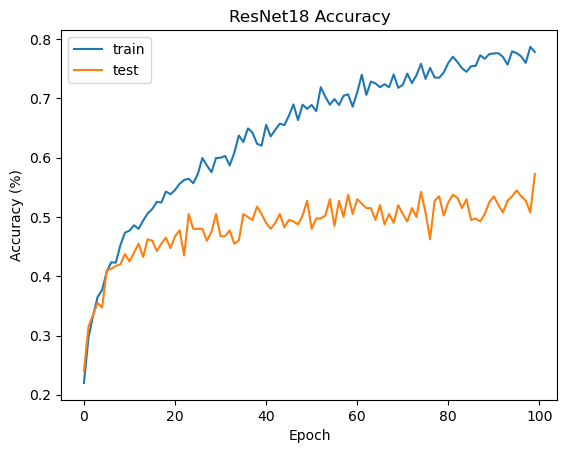

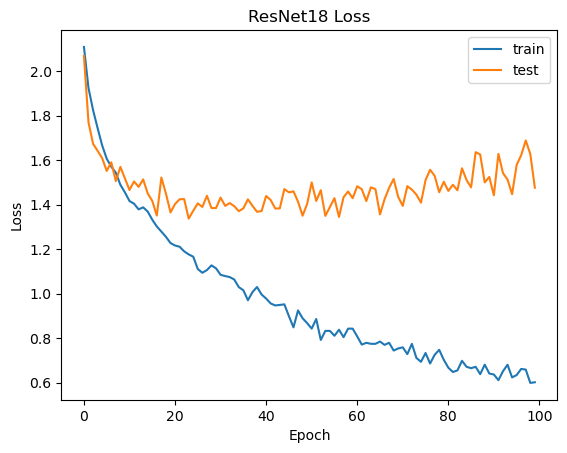

In [9]:
# plot train and test accuracy
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.title('ResNet18 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# plot train and test loss
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('ResNet18 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
import torchsummary

torchsummary.summary(model, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          896
├─ReLU: 1-2                              [-1, 32, 32, 32]          --
├─BatchNorm2d: 1-3                       [-1, 32, 32, 32]          64
├─Conv2d: 1-4                            [-1, 32, 32, 32]          9,248
├─ReLU: 1-5                              [-1, 32, 32, 32]          --
├─BatchNorm2d: 1-6                       [-1, 32, 32, 32]          64
├─AvgPool2d: 1-7                         [-1, 32, 16, 16]          --
├─Conv2d: 1-8                            [-1, 32, 16, 16]          9,248
├─ReLU: 1-9                              [-1, 32, 16, 16]          --
├─BatchNorm2d: 1-10                      [-1, 32, 16, 16]          64
├─Conv2d: 1-11                           [-1, 32, 16, 16]          9,248
├─ReLU: 1-12                             [-1, 32, 16, 16]          --
├─BatchNorm2d: 1-13                      [-1, 32, 16, 16]          64
├─Avg

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          896
├─ReLU: 1-2                              [-1, 32, 32, 32]          --
├─BatchNorm2d: 1-3                       [-1, 32, 32, 32]          64
├─Conv2d: 1-4                            [-1, 32, 32, 32]          9,248
├─ReLU: 1-5                              [-1, 32, 32, 32]          --
├─BatchNorm2d: 1-6                       [-1, 32, 32, 32]          64
├─AvgPool2d: 1-7                         [-1, 32, 16, 16]          --
├─Conv2d: 1-8                            [-1, 32, 16, 16]          9,248
├─ReLU: 1-9                              [-1, 32, 16, 16]          --
├─BatchNorm2d: 1-10                      [-1, 32, 16, 16]          64
├─Conv2d: 1-11                           [-1, 32, 16, 16]          9,248
├─ReLU: 1-12                             [-1, 32, 16, 16]          --
├─BatchNorm2d: 1-13                      [-1, 32, 16, 16]          64
├─Avg

(b) Remove the identity mapping and repeat (a), then make some discussion on the results of (a) and (b). Please **describe** what you found.